In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import scipy.io as sio
from datetime import datetime, timedelta
import gsw
import matplotlib.dates as mdates
import matplotlib.ticker as tick
import matplotlib.cm as cm
from matplotlib.gridspec import GridSpec
%matplotlib inline
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [2]:
import matplotlib.collections as collections
from numpy.fft import fft, ifft, fftshift, fftfreq
import pywt
from scipy import signal
import matplotlib as mpl
from scipy.interpolate import griddata

from sklearn.linear_model import LinearRegression

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## funciones

In [3]:
def to_data(date,da,s,temp):
    x = pd.DataFrame({'Datetime': pd.to_datetime(date, format='%d-%b-%Y %H:%M:%S'), 'Depth': da[:,0], 'Salinity': s[:,0], 'Temperature': temp[:,0]})
    x = x.set_index('Datetime')
    return x  

In [4]:
def to_density(z, sal, temp, lat):
    p = gsw.p_from_z(-z, lat)
    rho = gsw.rho_t_exact(sal, temp, p)
    return rho

In [5]:
def earth_to_uv(dfe, dfn, a): 
    "This takes 2 dataframes of east and north coordinates respectively and the regresion coeficient and transforms them to the direction of the coeficient"
    alpha = np.arctan(a) #Ángulo
    t, b = dfe.shape 
    M = np.array([[-np.cos(alpha), np.sin(alpha)],
                  [np.sin(alpha), np.cos(alpha)]]) #Matriz de transfomación
    columns = dfe.columns
    u = np.zeros((0,t)) #Inicialización de variables
    v = np.zeros((0,t)) #Inicialización de variables
    for i in columns: #Iteración sobre las columnas de los dataframes
        bin_ = np.array([[dfe[i].values],
                        [dfn[i].values]]) # Matriz de coordenadas east-north
        ui, vi = np.tensordot(M, bin_, 1) #Multiplicación matricial
        u = np.concatenate((u, ui), axis=0) #Unión de los resultados de u
        v = np.concatenate((v, vi), axis=0)#Unión de los resultados de v
    return u, v

In [6]:
import math

def haversine(lat1, lon1, lat2, lon2):
    rad = math.pi/180
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    R = 6372.795477598 # km radio de la tierra
    a = (math.sin(rad*dlat/2))**2 + math.cos(rad*lat1)*math.cos(rad*lat2)*(math.sin(rad*dlon/2))**2
    dist = 2*R*math.asin(math.sqrt(a))
    return dist

# Importar y arreglar datos

In [7]:
# feb16 = xr.open_dataset("data/adcp2012feb.nc")
# newfeb = feb16.sel(time=slice("2012-02-17","2012-03-08"))
# adcp = xr.open_dataset("C://Users//Dhannai//Documents//git//dump//adcp//data//adcp2012feb.nc")

# UV_burst = xr.open_dataset("data/UV_burst.nc")
# EN_burst = xr.open_dataset("data/EastNorth_burst.nc")
# vert_burst = pd.read_csv('burst_vert.csv')

In [8]:
# adcp = xr.open_dataset("C://Users//dhann//Documents//git//dump//adcp//data//adcp2012feb.nc")
# adcp = xr.open_dataset("C://Users//Dhannai//Documents//git//dump//adcp//data//adcp2012feb.nc")

In [9]:
#Convertir velocidades a DataFrames
# columnas = ['bin_1','bin_2','bin_3','bin_4','bin_5','bin_6','bin_7','bin_8','bin_9','bin_10','bin_11','bin_12','bin_13','bin_14','bin_15','bin_16','bin_17','bin_18','bin_19','bin_20','bin_21','bin_22','bin_23','bin_24','bin_25']

# df_east = pd.DataFrame(EN_burst.east.values, columns = columnas)
# df_east.index = EN_burst.time.values

# df_north = pd.DataFrame(EN_burst.north.values, columns = columnas)
# df_north.index = EN_burst.time.values

# u, v = earth_to_uv(df_east, df_north, 1.13493621)

# df_u = pd.DataFrame(np.transpose(u), columns = columnas)
# df_u.index = EN_burst.time.values

# df_v = pd.DataFrame(np.transpose(v), columns = columnas)
# df_v.index = EN_burst.time.values

# vert_burst.index = pd.to_datetime(vert_burst['Unnamed: 0'], format='%Y-%m-%d %H:%M:%S')
# vert_burst = vert_burst.drop(['Unnamed: 0'], axis=1)

In [10]:
DC = sio.loadmat("C://Users//Dhannai//OneDrive//Documents//Magister//Estuario Pescadero//janmar2012//wdates_local//DC_ctds_localdates.mat")
NM = sio.loadmat("C://Users//Dhannai//OneDrive//Documents//Magister//Estuario Pescadero//janmar2012//wdates_local//NM_ctds_localdates.mat")
ML = sio.loadmat("C://Users//Dhannai//OneDrive//Documents//Magister//Estuario Pescadero//janmar2012//wdates_local//AC_ctds_localdates.mat")
PC = sio.loadmat("C://Users//Dhannai//OneDrive//Documents//Magister//Estuario Pescadero//janmar2012//wdates_local//PC_ctds_localdates.mat")

# DC = sio.loadmat("C://Users//dhann//OneDrive//Documents//Magister//Estuario Pescadero//janmar2012//wdates_local//DC_ctds_localdates.mat")
# NM = sio.loadmat("C://Users//dhann//OneDrive//Documents//Magister//Estuario Pescadero//janmar2012//wdates_local//NM_ctds_localdates.mat")
# ML = sio.loadmat("C://Users//dhann//OneDrive//Documents//Magister//Estuario Pescadero//janmar2012//wdates_local//AC_ctds_localdates.mat")
# PC = sio.loadmat("C://Users//dhann//OneDrive//Documents//Magister//Estuario Pescadero//janmar2012//wdates_local//PC_ctds_localdates.mat")

In [11]:
DC_1 = to_data(DC['tdate_dc1'], DC['da_dc1'], DC['s_dc1'], DC['temp_dc1'])
DC_2 = to_data(DC['tdate_dc2'], DC['da_dc2'], DC['s_dc2'], DC['temp_dc2'])
DC_3 = to_data(DC['tdate_dc3'], DC['da_dc3'], DC['s_dc3'], DC['temp_dc3'])
DC_4 = to_data(DC['tdate_dc4'], DC['da_dc4'], DC['s_dc4'], DC['temp_dc4'])

NM_1 = to_data(NM['tdate_nm1'], NM['da_nm1'], NM['s_nm1'], NM['temp_nm1'])
NM_2 = to_data(NM['tdate_nm2'], NM['da_nm2'], NM['s_nm2'], NM['temp_nm2'])
NM_3 = to_data(NM['tdate_nm3'], NM['da_nm3'], NM['s_nm3'], NM['temp_nm3'])

ML_1 = to_data(ML['tdate_ac1'], ML['da_ac1'], ML['s_ac1'], ML['temp_ac1'])
ML_2 = to_data(ML['tdate_ac2'], ML['da_ac2'], ML['s_ac2'], ML['temp_ac2'])

PC_1 = to_data(PC['tdate_pc'], PC['da_pc'], PC['s_pc'], PC['temp_pc'])

In [12]:
NM_1 = to_data(NM['tdate_nm1'], NM['da_nm1'], NM['s_nm1'], NM['temp_nm1'])
NM_2 = to_data(NM['tdate_nm2'], NM['da_nm2'], NM['s_nm2'], NM['temp_nm2'])
NM_3 = to_data(NM['tdate_nm3'], NM['da_nm3'], NM['s_nm3'], NM['temp_nm3'])

In [13]:
#Viento
df2 = pd.read_table('C://Users//Dhannai//OneDrive//Documents//Magister//Estuario Pescadero//meteorological_station//raw//CR200Series_sixmin_pescadero_20120301.dat', sep=",", header=[1, 2, 3])
df2 = pd.DataFrame(df2.values, columns = ['TIMESTAMP','RECORD','Speed','Direction','Winddir_D2','airTC','RH'])
df2 = df2.set_index('TIMESTAMP')
df3 = pd.read_table('C://Users//Dhannai//OneDrive//Documents//Magister//Estuario Pescadero//meteorological_station//raw//CR200Series_sixmin_pescadero_20120419.dat', sep=",", header=[1, 2, 3])
df3 = pd.DataFrame(df3.values, columns = ['TIMESTAMP','RECORD','Speed','Direction','Winddir_D2','airTC','RH'])
df3 = df3.set_index('TIMESTAMP')
result = pd.concat([df2, df3], ignore_index=False, sort=False)
result.index = pd.to_datetime(result.index)
w = result

In [14]:
north_w = np.float64(w['Speed'])*np.sin(np.pi*np.float64(w['Direction'])/180)
east_w = np.float64(w['Speed'])*np.cos(np.pi*np.float64(w['Direction'])/180)
north_w = pd.DataFrame(data=north_w, columns=['viento'])
east_w = pd.DataFrame(data=east_w, columns=['viento'])

uw, vw = earth_to_uv(east_w, north_w, 0.79970532)

dfw = pd.DataFrame(np.transpose(np.array([uw[0,:], vw[0,:]])), columns=['u', 'v'])
dfw.index = w.index

In [15]:
#Leer datos caudal
Q = pd.read_csv("data\\febmar2012.csv")
lista_nombres= ["nan1", "fecha", "nan2", "sensor", 
                "caudal", "A"]
Q.columns=lista_nombres
Q = Q.drop(columns=['nan1', 'nan2', 'sensor', 'A']).reset_index()
Q = Q.drop(columns=['level_0', 'level_1'])
Q["fecha"] = pd.to_datetime(Q["fecha"].values)

In [16]:
#Importar caudal de pescadero cada 15 min en GMT
# https://nwis.waterservices.usgs.gov/nwis/iv/?sites=11162500&parameterCd=00060&startDT=2011-07-07T00:00:00.000-07:00&endDT=2012-07-07T23:59:59.999-07:00&siteStatus=all&format=rdb
Q = pd.read_csv("data\\caudal2012.csv", sep=';')
Q = Q.drop(['5s', '15s', '14n', 'Unnamed: 6'], axis=1)
Q['index'] = pd.to_datetime(Q['20d'] + ' ' + Q['6s'], format='%d-%m-%Y %H:%M')
Q = Q.set_index('index')
Q = Q.drop(['20d', '6s'], axis=1)

In [17]:
#Importar nivel de agua cada 6 min en hora local
snfco = pd.read_csv("data/CO-OPS_9414290_met.csv")
snfco = snfco.drop(['Predicted (m)', 'Preliminary (m)'], axis=1)
snfco['index'] = pd.to_datetime(snfco['Date'] + ' ' + snfco['Time (LST/LDT)'], format='%Y-%m-%d %H:%M')
snfco = snfco.set_index('index')
snfco = snfco.drop(['Date', 'Time (LST/LDT)'], axis=1)

mnty = pd.read_csv("data/CO-OPS_9413450_met.csv")
mnty = mnty.drop(['Predicted (m)', 'Preliminary (m)'], axis=1)
mnty['index'] = pd.to_datetime(mnty['Date'] + ' ' + mnty['Time (LST/LDT)'], format='%Y-%m-%d %H:%M')
mnty = mnty.set_index('index')
mnty = mnty.drop(['Date', 'Time (LST/LDT)'], axis=1)

In [18]:
#Importar datos boya 46012 (Half moon bay)
# https://www.ndbc.noaa.gov/station_history.php?station=46012
hmoon = pd.read_csv("data/46012h2012.csv", sep=';', header=0)
hmoon = hmoon.drop(['PRES','TIDE', 'ATMP', 'WTMP','DEWP', 'VIS', 'WDI', 'R WSP', 'D GST'], axis=1)
hmoon = hmoon.drop([0], axis=0)
hmoon['index'] = pd.to_datetime(hmoon['#YY'] + '-' + hmoon['MM'] + '-' + hmoon['DD'] + ' ' + hmoon['hh'] + ':' + hmoon['mm'], format='%Y-%m-%d %H:%M')
hmoon = hmoon.set_index('index')
hmoon = hmoon.drop(['#YY', 'MM', 'DD', 'hh', 'mm'], axis=1)
hmoon['WVHT'] = hmoon['WVHT'].astype('float64')
hmoon['DPD'] = hmoon['DPD'].astype('float64')
hmoon['APD'] = hmoon['APD'].astype('float64')
hmoon['MWD'] = hmoon['MWD'].astype('float64')
hmoon = hmoon.drop([datetime(2012,2,14,19,50,0), datetime(2012,2,22,11,50,0), datetime(2012,2,23,11,50,0)], axis=0)
# WVHT: Significant wave height
# DPD: Dominant wave period (seconds) is the period with the maximum wave energy.
# APD: Average wave period (seconds) of all waves during the 20-minute period. 

In [19]:
#Importar datos de backscatter
# bks_drp = np.load("C://Users//Dhannai//Documents//git//dump//bks_drp.npy")
# bks_drp1 = np.load("C://Users//Dhannai//Documents//git//dump//bks_drp1.npy")
# bks_drp2 = np.load("C://Users//Dhannai//Documents//git//dump//bks_drp2.npy")
# bks_drp3 = np.load("C://Users//Dhannai//Documents//git//dump//bks_drp3.npy")
# bks_drp4 = np.load("C://Users//Dhannai//Documents//git//dump//bks_drp4.npy")

# bks_drp1 = np.load("data/bks_drp1.npy")
# bks_drp2 = np.load("data/bks_drp2.npy")
# bks_drp3 = np.load("data/bks_drp3.npy")
# bks_drp4 = np.load("data/bks_drp4.npy")

## Perfiles

In [20]:
p1 = pd.read_csv("data/perfil1.csv", sep=';')
p1 = p1.drop(['Conductividad', 'Presión', 'Turbidez','Conduct Especifica', 'Density anomaly', 'C'], axis=1)

## Densidad

In [21]:
# rho_dc1 = to_density(DC_1['Depth'], DC_1['Salinity'], DC_1['Temperature'], 37.26)
# rho_dc2 = to_density(DC_2['Depth'], DC_2['Salinity'], DC_2['Temperature'], 37.26)
# rho_dc3 = to_density(DC_3['Depth'], DC_3['Salinity'], DC_3['Temperature'], 37.26)
# rho_dc4 = to_density(DC_4['Depth'], DC_4['Salinity'], DC_4['Temperature'], 37.26)

# DC_1['densidad'] = rho_dc1
# DC_2['densidad'] = rho_dc2
# DC_3['densidad'] = rho_dc3
# DC_4['densidad'] = rho_dc4

In [22]:
# rho_nm1 = to_density(NM_1['Depth'], NM_1['Salinity'], NM_1['Temperature'], 37.26)
# rho_nm2 = to_density(NM_2['Depth'], NM_2['Salinity'], NM_2['Temperature'], 37.26)
# rho_nm3 = to_density(NM_3['Depth'], NM_3['Salinity'], NM_3['Temperature'], 37.26)

# NM_1['densidad'] = rho_nm1
# NM_2['densidad'] = rho_nm2
# NM_3['densidad'] = rho_nm3

In [23]:
# rho_ml1 = to_density(ML_1['Depth'], ML_1['Salinity'], ML_1['Temperature'], 37.26)
# rho_ml2 = to_density(ML_2['Depth'], ML_2['Salinity'], ML_2['Temperature'], 37.26)

# ML_1['densidad'] = rho_ml1
# ML_2['densidad'] = rho_ml2

In [24]:
# rho_pc = to_density(PC_1['Depth'], PC_1['Salinity'], PC_1['Temperature'], 37.26)

# PC_1['densidad'] = rho_pc

## viento

In [25]:
rho_air = 1.2
cd = 0.0012

dfw = rho_air*cd*dfw*abs(dfw)

# Revision de datos

In [26]:
dc1 = DC_1.loc[datetime(2012,2,11,0,0,0):datetime(2012,2,24,21,5,0)]

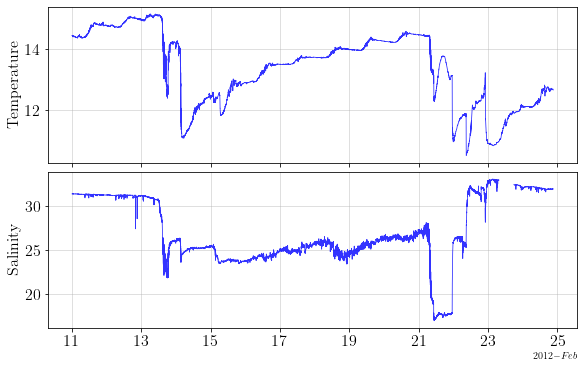

In [27]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(8, 5), constrained_layout=True, sharex=True)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

ax1.set_ylabel(r"Temperature ",
          fontsize=16)

ax1.plot(dc1.index, dc1["Temperature"].values, c='b', alpha=0.8, linewidth=0.8, label='top-bottom')

ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)
ax1.grid(alpha=0.5)

ax2.set_ylabel(r"Salinity ",
          fontsize=16)

ax2.plot(dc1.index, dc1["Salinity"].values, c='b', alpha=0.8, linewidth=0.8, label='top-bottom')

ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)
ax2.grid(alpha=0.5)

# ax2.set_xlim(datetime(2012,1,17,14,0,0), datetime(2012,1,21,12,0,0))



# Ajustar formato fecha
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)

In [20]:
## Esta funcion considera que el ultimo número es un valor correcto 
## Verificar antes que el ultimo valor esté ok
def del_err(ds):
    for i in range(len(ds)-2, 0, -1):
        if np.isnan(ds[i]):
            if abs(ds[i+1] - ds[i-1])>ds[i-50:i+50].std(skipna=True):
                ds = ds.drop(ds.index[i+1])
        if abs(ds[i] - ds[i-1])>ds[i-50:i+50].std(skipna=True):
            ds = ds.drop(ds.index[i])                                   
        if abs(ds[i] - ds[i-1])>0.8:
            ds = ds.drop(ds.index[i])                                   

    return ds  

In [21]:
def del_err2(ds):
    for i in range(0, len(ds), 1000):
        if ds[i:i+1].std(skipna=True) > 1:
            min_val = ds[i:i+1].mean(skipna=True) - ds[i:i+1].std(skipna=True)
            m = np.where(ds[i:i+1].values < min_val)
            ds[m+i] = np.nan
    return ds

In [30]:
minval = del_err(DC_2["Salinity"])

In [31]:
minval

Datetime
2012-01-17 11:30:00    0.000000
2012-01-17 11:30:10    0.007433
2012-01-17 11:30:20    0.000000
2012-01-17 11:30:30    0.000000
2012-01-17 11:30:40    0.000000
                         ...   
2012-03-20 12:43:40         NaN
2012-03-20 12:43:50         NaN
2012-03-20 12:44:00         NaN
2012-03-20 12:44:10         NaN
2012-03-20 12:44:20         NaN
Name: Salinity, Length: 496929, dtype: float64

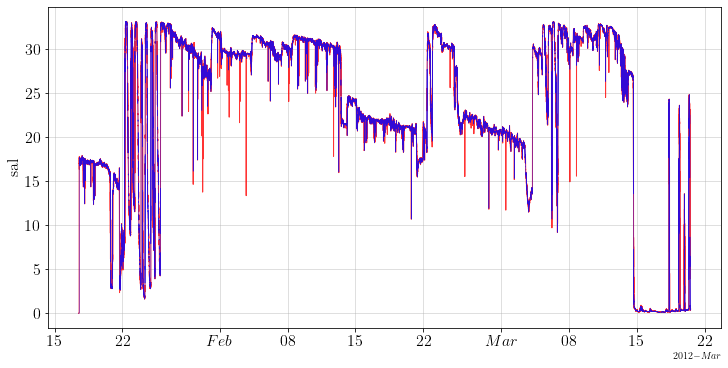

In [50]:
fig, (ax1) = plt.subplots(nrows=1, figsize=(10, 5), constrained_layout=True, sharex=True)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

ax1.set_ylabel(r"sal ",
          fontsize=16)

ax1.plot(DC_2.index, DC_2["Salinity"].values, c='r', alpha=0.8, linewidth=1, label='top-bottom')
ax1.plot(minval.index, minval.values, c='b', alpha=0.8, linewidth=0.5, label='top-bottom')

ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)
ax1.grid(alpha=0.5)


# Ajustar formato fecha
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)

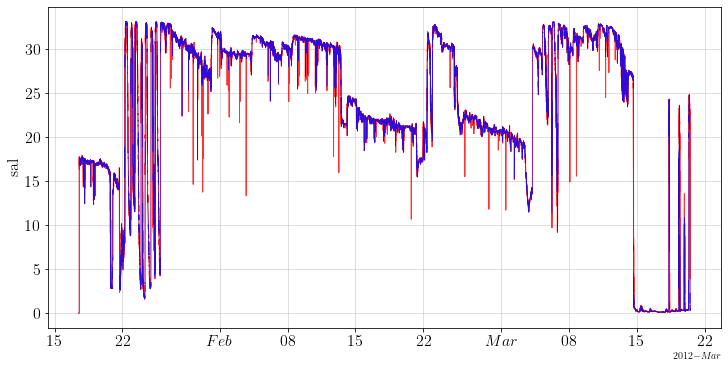

In [53]:
fig, (ax1) = plt.subplots(nrows=1, figsize=(10, 5), constrained_layout=True, sharex=True)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

ax1.set_ylabel(r"sal ",
          fontsize=16)

ax1.plot(DC_2.index, DC_2["Salinity"].values, c='r', alpha=0.8, linewidth=1, label='top-bottom')
ax1.plot(minval.index, minval.values, c='b', alpha=0.8, linewidth=0.5, label='top-bottom')

ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)
ax1.grid(alpha=0.5)


# Ajustar formato fecha
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)

In [32]:
dc1 = DC_1.loc[datetime(2012,2,11):datetime(2012,3,8)]
dc2 = DC_2.loc[datetime(2012,2,11):datetime(2012,3,8)]

In [22]:
DC_1["Sal_del"] = del_err(DC_1["Salinity"])
DC_2["Sal_del"] = del_err(DC_2["Salinity"])
DC_3["Sal_del"] = del_err(DC_3["Salinity"])
DC_4["Sal_del"] = del_err(DC_4["Salinity"])

In [23]:
NM_2["Sal_del"] = del_err(NM_2["Salinity"])
NM_3["Sal_del"] = del_err(NM_3["Salinity"])
NM_1["Sal_del"] = del_err(NM_1["Salinity"])

In [24]:
ML_2["Sal_del"] = del_err(ML_2["Salinity"])
ML_1["Sal_del"] = del_err(ML_1["Salinity"])

In [25]:
PC_1["Sal_del"] = del_err(PC_1["Salinity"])

In [26]:
DC_1["Sal_del"] = del_err(DC_1["Sal_del"])
DC_2["Sal_del"] = del_err(DC_2["Sal_del"])
DC_3["Sal_del"] = del_err(DC_3["Sal_del"])
DC_4["Sal_del"] = del_err(DC_4["Sal_del"])

In [27]:
NM_2["Sal_del"] = del_err(NM_2["Sal_del"])
NM_3["Sal_del"] = del_err(NM_3["Sal_del"])
NM_1["Sal_del"] = del_err(NM_1["Sal_del"])

In [28]:
ML_2["Sal_del"] = del_err(ML_2["Sal_del"])
ML_1["Sal_del"] = del_err(ML_1["Sal_del"])

In [29]:
PC_1["Sal_del"] = del_err(PC_1["Sal_del"])

In [30]:
t1 = np.arange(datetime(2012,1,17,12,30,0), datetime(2012,1,17,14,0,0), timedelta(seconds=10)).astype(datetime)
t5 = np.arange(datetime(2012,1,17,11,30,0), datetime(2012,1,17,14,0,0), timedelta(seconds=10)).astype(datetime)
t6 = np.arange(datetime(2012,1,17,11,10,0), datetime(2012,1,17,14,0,0), timedelta(seconds=10)).astype(datetime)
t7 = np.arange(datetime(2012,1,17,12,10,0), datetime(2012,1,17,14,0,0), timedelta(seconds=10)).astype(datetime)
DC_1 = DC_1.drop(t1)
DC_2 = DC_2.drop(t5)
DC_3 = DC_3.drop(t6)
DC_4 = DC_4.drop(t7)

In [31]:
t2 = np.arange(datetime(2012,1,17,10,30,0), datetime(2012,1,17,14,0,0), timedelta(seconds=30)).astype(datetime)
t3 = np.arange(datetime(2012,1,17,6,0,0), datetime(2012,1,17,14,0,0), timedelta(seconds=30)).astype(datetime)
t4 = np.arange(datetime(2012,1,17,6,0,0), datetime(2012,1,17,14,0,0), timedelta(seconds=10)).astype(datetime)
NM_2 = NM_2.drop(t2)
NM_3 = NM_3.drop(t3)
NM_1 = NM_1.drop(t4)

In [32]:
t8 = np.arange(datetime(2012,1,17,10,14,0), datetime(2012,1,17,14,0,0), timedelta(seconds=10)).astype(datetime)
t9 = np.arange(datetime(2012,1,17,10,0,0), datetime(2012,1,17,14,0,0), timedelta(seconds=30)).astype(datetime)
ML_2 = ML_2.drop(t9)
ML_1 = ML_1.drop(t8)

In [33]:
t10 = np.arange(datetime(2012,1,17,6,0,0), datetime(2012,1,17,14,0,0), timedelta(seconds=30)).astype(datetime)

PC_1 = PC_1.drop(t10)

In [37]:
sec30 = pd.date_range(start=datetime(2012,2,11), end=datetime(2012,3,3), periods=None, freq='30S')
sec10 = pd.date_range(start=datetime(2012,2,11), end=datetime(2012,3,3), periods=None, freq='10S')

In [49]:
ML_2

,Depth,Salinity,Temperature,Sal_del
Datetime,,,,
2012-01-17 10:00:10,0.029796,0.006885,13.057532,0.006885
2012-01-17 10:00:20,0.028653,0.006814,13.157889,0.006814
2012-01-17 10:00:40,0.028362,0.006987,13.165594,0.006987
2012-01-17 10:00:50,0.027970,0.006843,13.209657,0.006843
2012-01-17 10:01:10,0.027703,0.007019,13.421892,0.007019
...,...,...,...,...
2012-03-20 07:03:30,0.347023,0.391191,9.243740,NaN
2012-03-20 07:03:40,0.345334,0.430145,9.252369,NaN
2012-03-20 07:03:50,0.345040,0.384487,9.268210,NaN


KeyError: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: DatetimeIndex(['2012-02-11 07:11:30', '2012-02-11 07:12:00',\n               '2012-02-11 07:12:30', '2012-02-11 07:13:00',\n               '2012-02-11 07:13:30',\n               ...\n               '2012-02-11 07:20:00', '2012-02-11 07:20:30',\n               '2012-02-11 07:21:00', '2012-02-11 07:21:30',\n               '2012-02-11 07:22:00'],\n              dtype='datetime64[ns]', length=22, freq='30S'). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"

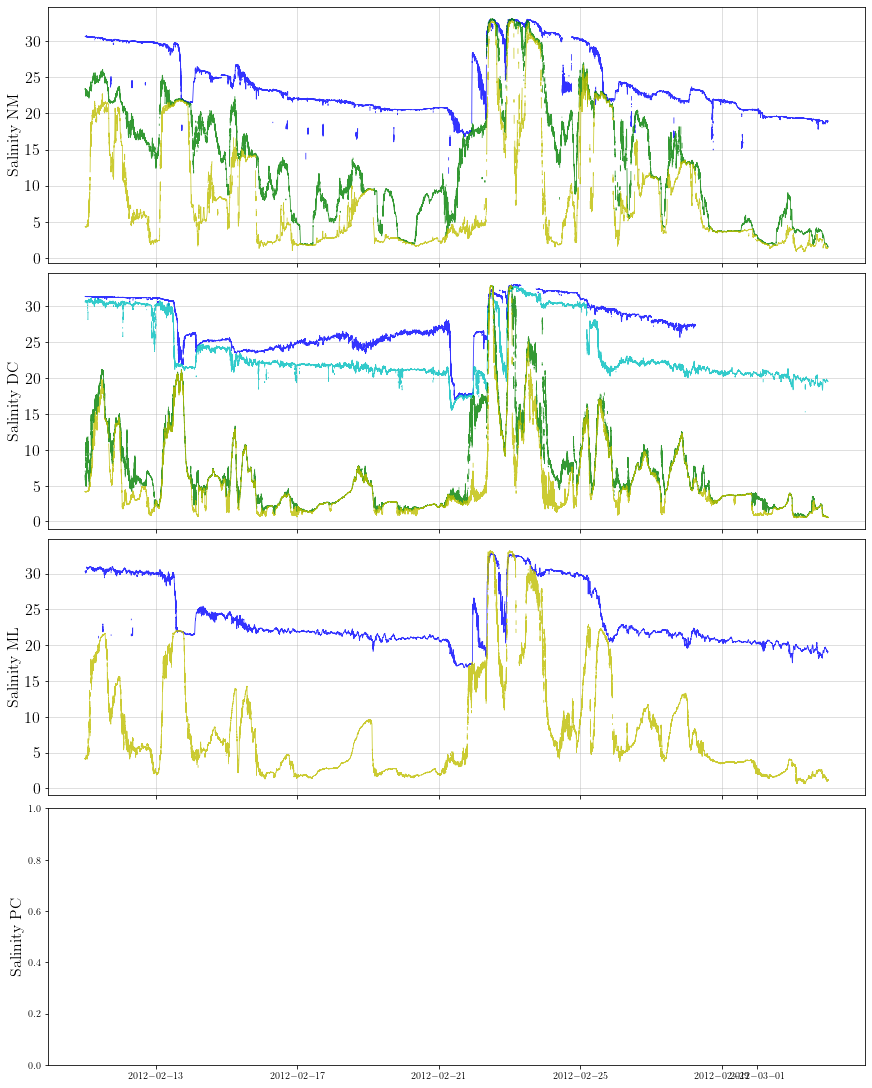

In [63]:
sec30 = pd.date_range(start=datetime(2012,2,11), end=datetime(2012,3,3), periods=None, freq='30S')
sec10 = pd.date_range(start=datetime(2012,2,11), end=datetime(2012,3,3), periods=None, freq='10S')

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, figsize=(12, 15), constrained_layout=True, sharex=True)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

ax1.set_ylabel(r"Salinity NM ",
          fontsize=16)

# ax1.plot(NM_1.index, NM_1["Salinity"].values, c='r', alpha=0.8, linewidth=0.8, label='top-bottom')
ax1.plot(sec10, NM_1["Sal_del"][sec10].values, c='b', alpha=0.8, linewidth=0.8, label='top-bottom')

# ax1.plot(NM_2.index, NM_2["Salinity"].values, c='r', alpha=0.8, linewidth=0.8, label='top-bottom')
ax1.plot(sec30, NM_2["Sal_del"][sec30].values, c='g', alpha=0.8, linewidth=0.8, label='top-bottom')

# ax1.plot(NM_3.index, NM_3["Salinity"].values, c='r', alpha=0.8, linewidth=0.8, label='top-bottom')
ax1.plot(sec30, NM_3["Sal_del"][sec30].values, c='y', alpha=0.8, linewidth=0.8, label='top-bottom')

ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)
ax1.grid(alpha=0.5)

ax2.set_ylabel(r"Salinity DC",
          fontsize=16)

# ax2.plot(DC_1.index, DC_1["Salinity"].values, c='r', alpha=0.8, linewidth=0.8, label='top-bottom')
ax2.plot(sec10, DC_1["Sal_del"][sec10].values, c='b', alpha=0.8, linewidth=0.8, label='top-bottom')

# ax2.plot(DC_2.index, DC_2["Salinity"].values, c='r', alpha=0.8, linewidth=0.8, label='top-bottom')
ax2.plot(sec10, DC_2["Sal_del"][sec10].values, c='c', alpha=0.8, linewidth=0.8, label='top-bottom')

# ax2.plot(DC_3.index, DC_3["Salinity"].values, c='r', alpha=0.8, linewidth=0.8, label='top-bottom')
ax2.plot(sec10, DC_3["Sal_del"][sec10].values, c='g', alpha=0.8, linewidth=0.8, label='top-bottom')

# ax2.plot(DC_4.index, DC_4["Salinity"].values, c='r', alpha=0.8, linewidth=0.8, label='top-bottom')
ax2.plot(sec10, DC_4["Sal_del"][sec10].values, c='y', alpha=0.8, linewidth=0.8, label='top-bottom')

ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)
ax2.grid(alpha=0.5)

# ax2.set_xlim(datetime(2012,1,17,14,0,0), datetime(2012,1,21,12,0,0))
ax3.set_ylabel(r"Salinity ML ",
          fontsize=16)

# ax3.plot(ML_1.index, ML_1["Salinity"].values, c='r', alpha=0.8, linewidth=0.8, label='top-bottom')
ax3.plot(sec10, ML_1["Sal_del"][sec10].values, c='b', alpha=0.8, linewidth=0.8, label='top-bottom')

# ax3.plot(ML_2.index, ML_2["Salinity"].values, c='r', alpha=0.8, linewidth=0.8, label='top-bottom')
ax3.plot(sec10, ML_2["Sal_del"][sec10].values, c='y', alpha=0.8, linewidth=0.8, label='top-bottom')



ax3.xaxis.set_tick_params(labelsize=16)
ax3.yaxis.set_tick_params(labelsize=16)
ax3.grid(alpha=0.5)


ax4.set_ylabel(r"Salinity PC ",
          fontsize=16)

# ax4.plot(PC_1.index, PC_1["Salinity"].values, c='r', alpha=0.8, linewidth=0.8, label='top-bottom')
# ax4.plot(sec30, PC_1["Sal_del"][sec30].values, c='b', alpha=0.8, linewidth=0.8, label='top-bottom')


ax4.xaxis.set_tick_params(labelsize=16)
ax4.yaxis.set_tick_params(labelsize=16)
ax4.grid(alpha=0.5)


# Ajustar formato fecha
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)

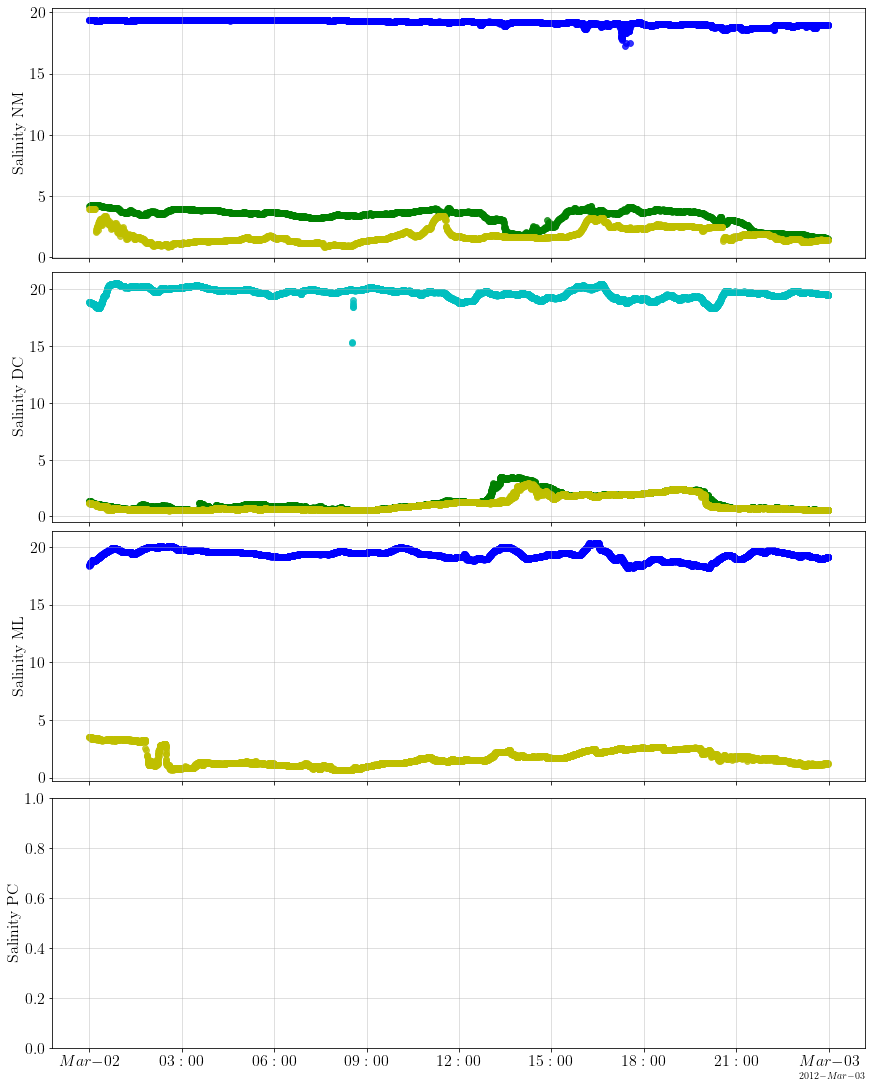

In [164]:
sec30 = pd.date_range(start=datetime(2012,3,2,0,0,0), end=datetime(2012,3,2,23,59,0), periods=None, freq='30S')
sec10 = pd.date_range(start=datetime(2012,3,2,0,0,0), end=datetime(2012,3,2,23,59,0), periods=None, freq='10S')

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, figsize=(12, 15), constrained_layout=True, sharex=True)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

ax1.set_ylabel(r"Salinity NM ",
          fontsize=16)

# ax1.plot(NM_1.index, NM_1["Salinity"].values, c='r', alpha=0.8, linewidth=0.8, label='top-bottom')
ax1.scatter(sec10, NM_1["Sal_del"][sec10].values, c='b', alpha=0.8, linewidth=0.8, label='top-bottom')

# ax1.plot(NM_2.index, NM_2["Salinity"].values, c='r', alpha=0.8, linewidth=0.8, label='top-bottom')
ax1.scatter(sec30, NM_2["Sal_del"][sec30].values, c='g', alpha=0.8, linewidth=0.8, label='top-bottom')

# ax1.plot(NM_3.index, NM_3["Salinity"].values, c='r', alpha=0.8, linewidth=0.8, label='top-bottom')
ax1.scatter(sec30, NM_3["Sal_del"][sec30].values, c='y', alpha=0.8, linewidth=0.8, label='top-bottom')

ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)
ax1.grid(alpha=0.5)

ax2.set_ylabel(r"Salinity DC",
          fontsize=16)

# ax2.plot(DC_1.index, DC_1["Salinity"].values, c='r', alpha=0.8, linewidth=0.8, label='top-bottom')
ax2.scatter(sec10, DC_1["Sal_del"][sec10].values, c='b', alpha=0.8, linewidth=0.8, label='top-bottom')

# ax2.plot(DC_2.index, DC_2["Salinity"].values, c='r', alpha=0.8, linewidth=0.8, label='top-bottom')
ax2.scatter(sec10, DC_2["Sal_del"][sec10].values, c='c', alpha=0.8, linewidth=0.8, label='top-bottom')

# ax2.plot(DC_3.index, DC_3["Salinity"].values, c='r', alpha=0.8, linewidth=0.8, label='top-bottom')
ax2.scatter(sec10, DC_3["Sal_del"][sec10].values, c='g', alpha=0.8, linewidth=0.8, label='top-bottom')

# ax2.plot(DC_4.index, DC_4["Salinity"].values, c='r', alpha=0.8, linewidth=0.8, label='top-bottom')
ax2.scatter(sec10, DC_4["Sal_del"][sec10].values, c='y', alpha=0.8, linewidth=0.8, label='top-bottom')

ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)
ax2.grid(alpha=0.5)

# ax2.set_xlim(datetime(2012,1,17,14,0,0), datetime(2012,1,21,12,0,0))
ax3.set_ylabel(r"Salinity ML ",
          fontsize=16)

# ax3.plot(ML_1.index, ML_1["Salinity"].values, c='r', alpha=0.8, linewidth=0.8, label='top-bottom')
ax3.scatter(sec10, ML_1["Sal_del"][sec10].values, c='b', alpha=0.8, linewidth=0.8, label='top-bottom')

# ax3.plot(ML_2.index, ML_2["Salinity"].values, c='r', alpha=0.8, linewidth=0.8, label='top-bottom')
ax3.scatter(sec10, ML_2["Sal_del"][sec10].values, c='y', alpha=0.8, linewidth=0.8, label='top-bottom')



ax3.xaxis.set_tick_params(labelsize=16)
ax3.yaxis.set_tick_params(labelsize=16)
ax3.grid(alpha=0.5)


ax4.set_ylabel(r"Salinity PC ",
          fontsize=16)

# ax4.plot(PC_1.index, PC_1["Salinity"].values, c='r', alpha=0.8, linewidth=0.8, label='top-bottom')
# ax4.scatter(sec30, PC_1["Sal_del"][sec30].values, c='b', alpha=0.8, linewidth=0.8, label='top-bottom')


ax4.xaxis.set_tick_params(labelsize=16)
ax4.yaxis.set_tick_params(labelsize=16)
ax4.grid(alpha=0.5)


# Ajustar formato fecha
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)

In [166]:
## ready

t2 = np.arange(datetime(2012,2,13,17,35,0), datetime(2012,2,13,17,40,0), timedelta(seconds=10)).astype(datetime)
t3 = np.arange(datetime(2012,2,12,16,49,0), datetime(2012,2,12,16,51,0), timedelta(seconds=10)).astype(datetime)
t4 = np.arange(datetime(2012,2,11,17,5,0), datetime(2012,2,11,17,34,0), timedelta(seconds=10)).astype(datetime)
t5 = np.arange(datetime(2012,2,17,5,43,0), datetime(2012,2,17,5,44,0), timedelta(seconds=10)).astype(datetime)
t6 = np.arange(datetime(2012,2,17,7,10,0), datetime(2012,2,17,7,16,40), timedelta(seconds=10)).astype(datetime)
t7 = np.arange(datetime(2012,2,17,17,8,0), datetime(2012,2,17,17,18,0), timedelta(seconds=10)).astype(datetime)
t8 = np.arange(datetime(2012,2,17,17,25,0), datetime(2012,2,17,17,32,0), timedelta(seconds=10)).astype(datetime)
t9 = np.arange(datetime(2012,2,18,15,45,0), datetime(2012,2,18,17,0,0), timedelta(seconds=10)).astype(datetime)
t10 = np.arange(datetime(2012,2,19,17,20,0), datetime(2012,2,19,17,31,0), timedelta(seconds=10)).astype(datetime)
t11 = np.arange(datetime(2012,2,21,6,35,30), datetime(2012,2,21,6,37,0), timedelta(seconds=10)).astype(datetime)
t12 = np.arange(datetime(2012,2,21,7,25,0), datetime(2012,2,21,7,35,0), timedelta(seconds=10)).astype(datetime)
t13 = np.arange(datetime(2012,2,26,10,20,0), datetime(2012,2,26,10,40,0), timedelta(seconds=10)).astype(datetime)
t14 = np.arange(datetime(2012,2,26,12,58,0), datetime(2012,2,26,13,4,0), timedelta(seconds=10)).astype(datetime)
t15 = np.arange(datetime(2012,2,27,15,4,0), datetime(2012,2,27,15,32,0), timedelta(seconds=10)).astype(datetime)
t16 = np.arange(datetime(2012,2,28,16,45,0), datetime(2012,2,28,18,15,0), timedelta(seconds=10)).astype(datetime)
t17 = np.arange(datetime(2012,2,29,13,18,0), datetime(2012,2,29,13,56,0), timedelta(seconds=10)).astype(datetime)


# NM_1 = NM_1.drop(t4)

In [167]:
NM_1 = NM_1.drop(t2)
NM_1 = NM_1.drop(t3)
NM_1 = NM_1.drop(t5)
NM_1 = NM_1.drop(t6)
NM_1 = NM_1.drop(t7)
NM_1 = NM_1.drop(t8)
NM_1 = NM_1.drop(t9)
NM_1 = NM_1.drop(t10)
NM_1 = NM_1.drop(t11)
NM_1 = NM_1.drop(t12)
NM_1 = NM_1.drop(t13)
NM_1 = NM_1.drop(t14)
NM_1 = NM_1.drop(t15)
NM_1 = NM_1.drop(t16)
NM_1 = NM_1.drop(t17)

In [170]:
## ready?
t8 = np.arange(datetime(2012,2,11,11,57,0), datetime(2012,2,11,12,6,0), timedelta(seconds=10)).astype(datetime)
t9 = np.arange(datetime(2012,2,11,9,7,30), datetime(2012,2,11,9,8,0), timedelta(seconds=10)).astype(datetime)
t10 = np.arange(datetime(2012,2,11,17,38,0), datetime(2012,2,11,17,39,0), timedelta(seconds=10)).astype(datetime)
t11 = np.arange(datetime(2012,2,12,7,18,0), datetime(2012,2,12,7,20,0), timedelta(seconds=10)).astype(datetime)
t12 = np.arange(datetime(2012,2,12,7,46,0), datetime(2012,2,12,7,53,40), timedelta(seconds=10)).astype(datetime)
t13 = np.arange(datetime(2012,2,12,8,5,50), datetime(2012,2,12,8,17,40), timedelta(seconds=10)).astype(datetime)
ML_1 = ML_1.drop(t8)
ML_1 = ML_1.drop(t9)
ML_1 = ML_1.drop(t10)
ML_1 = ML_1.drop(t11)
ML_1 = ML_1.drop(t12)
ML_1 = ML_1.drop(t13)

KeyError: '[datetime.datetime(2012, 2, 12, 8, 5, 50)\n datetime.datetime(2012, 2, 12, 8, 6, 20)\n datetime.datetime(2012, 2, 12, 8, 6, 50)\n datetime.datetime(2012, 2, 12, 8, 7, 20)\n datetime.datetime(2012, 2, 12, 8, 7, 50)\n datetime.datetime(2012, 2, 12, 8, 8, 20)\n datetime.datetime(2012, 2, 12, 8, 8, 50)\n datetime.datetime(2012, 2, 12, 8, 9, 20)\n datetime.datetime(2012, 2, 12, 8, 9, 50)\n datetime.datetime(2012, 2, 12, 8, 10, 20)\n datetime.datetime(2012, 2, 12, 8, 10, 50)\n datetime.datetime(2012, 2, 12, 8, 11, 20)\n datetime.datetime(2012, 2, 12, 8, 11, 50)\n datetime.datetime(2012, 2, 12, 8, 12, 20)\n datetime.datetime(2012, 2, 12, 8, 12, 50)\n datetime.datetime(2012, 2, 12, 8, 13, 20)\n datetime.datetime(2012, 2, 12, 8, 13, 50)\n datetime.datetime(2012, 2, 12, 8, 14, 20)\n datetime.datetime(2012, 2, 12, 8, 14, 50)\n datetime.datetime(2012, 2, 12, 8, 15, 20)\n datetime.datetime(2012, 2, 12, 8, 15, 50)\n datetime.datetime(2012, 2, 12, 8, 16, 20)\n datetime.datetime(2012, 2, 12, 8, 16, 50)\n datetime.datetime(2012, 2, 12, 8, 17, 20)] not found in axis'

In [60]:
# t10 = np.arange(datetime(2012,2,11,7,11,30), datetime(2012,2,11,7,22,30), timedelta(seconds=30)).astype(datetime)

# PC_1 = PC_1.drop(t10)

In [168]:
ML_1

,Depth,Salinity,Temperature,Sal_del
Datetime,,,,
2012-01-17 14:00:00,1.985532,18.144974,14.198721,18.144974
2012-01-17 14:00:10,1.986455,18.141768,14.197115,18.141768
2012-01-17 14:00:20,1.986539,18.136325,14.193508,18.136325
2012-01-17 14:00:30,1.986645,18.145485,14.195654,18.145485
2012-01-17 14:00:40,1.986203,18.157652,14.199678,18.157652
...,...,...,...,...
2012-03-23 01:55:10,0.156090,0.000000,20.330298,0.000000
2012-03-23 01:55:20,0.156369,0.000000,20.404093,0.000000
2012-03-23 01:55:30,0.156632,0.014072,20.194673,NaN


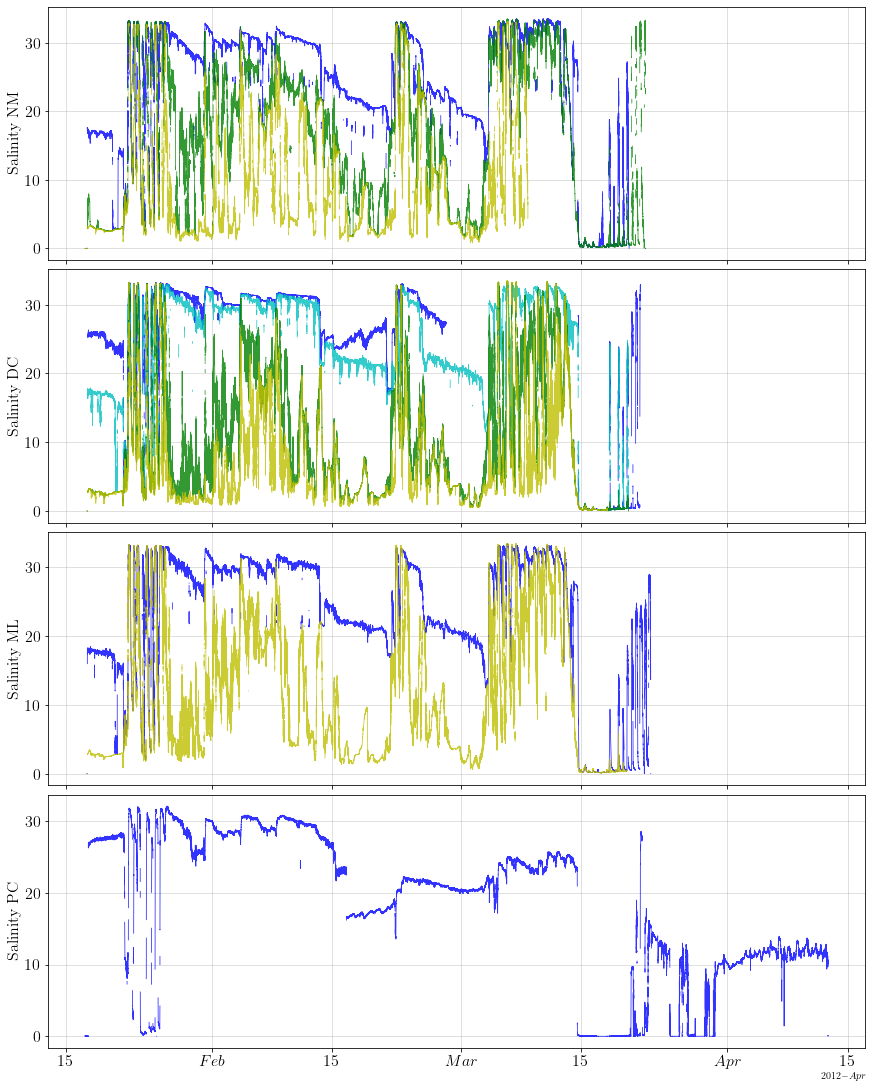

In [49]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, figsize=(12, 15), constrained_layout=True, sharex=True)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

ax1.set_ylabel(r"Salinity NM ",
          fontsize=16)

# ax1.plot(NM_1.index, NM_1["Salinity"].values, c='r', alpha=0.8, linewidth=0.8, label='top-bottom')
ax1.plot(NM_1.index, NM_1["Sal_del"].values, c='b', alpha=0.8, linewidth=0.8, label='top-bottom')

# ax1.plot(NM_2.index, NM_2["Salinity"].values, c='r', alpha=0.8, linewidth=0.8, label='top-bottom')
ax1.plot(NM_2.index, NM_2["Sal_del"].values, c='g', alpha=0.8, linewidth=0.8, label='top-bottom')

# ax1.plot(NM_3.index, NM_3["Salinity"].values, c='r', alpha=0.8, linewidth=0.8, label='top-bottom')
ax1.plot(NM_3.index, NM_3["Sal_del"].values, c='y', alpha=0.8, linewidth=0.8, label='top-bottom')

ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)
ax1.grid(alpha=0.5)

ax2.set_ylabel(r"Salinity DC",
          fontsize=16)

# ax2.plot(DC_1.index, DC_1["Salinity"].values, c='r', alpha=0.8, linewidth=0.8, label='top-bottom')
ax2.plot(DC_1.index, DC_1["Sal_del"].values, c='b', alpha=0.8, linewidth=0.8, label='top-bottom')

# ax2.plot(DC_2.index, DC_2["Salinity"].values, c='r', alpha=0.8, linewidth=0.8, label='top-bottom')
ax2.plot(DC_2.index, DC_2["Sal_del"].values, c='c', alpha=0.8, linewidth=0.8, label='top-bottom')

# ax2.plot(DC_3.index, DC_3["Salinity"].values, c='r', alpha=0.8, linewidth=0.8, label='top-bottom')
ax2.plot(DC_3.index, DC_3["Sal_del"].values, c='g', alpha=0.8, linewidth=0.8, label='top-bottom')

# ax2.plot(DC_4.index, DC_4["Salinity"].values, c='r', alpha=0.8, linewidth=0.8, label='top-bottom')
ax2.plot(DC_4.index, DC_4["Sal_del"].values, c='y', alpha=0.8, linewidth=0.8, label='top-bottom')

ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)
ax2.grid(alpha=0.5)

# ax2.set_xlim(datetime(2012,1,17,14,0,0), datetime(2012,1,21,12,0,0))
ax3.set_ylabel(r"Salinity ML ",
          fontsize=16)

# ax3.plot(ML_1.index, ML_1["Salinity"].values, c='r', alpha=0.8, linewidth=0.8, label='top-bottom')
ax3.plot(ML_1.index, ML_1["Sal_del"].values, c='b', alpha=0.8, linewidth=0.8, label='top-bottom')

# ax3.plot(ML_2.index, ML_2["Salinity"].values, c='r', alpha=0.8, linewidth=0.8, label='top-bottom')
ax3.plot(ML_2.index, ML_2["Sal_del"].values, c='y', alpha=0.8, linewidth=0.8, label='top-bottom')



ax3.xaxis.set_tick_params(labelsize=16)
ax3.yaxis.set_tick_params(labelsize=16)
ax3.grid(alpha=0.5)


ax4.set_ylabel(r"Salinity PC ",
          fontsize=16)

# ax4.plot(PC_1.index, PC_1["Salinity"].values, c='r', alpha=0.8, linewidth=0.8, label='top-bottom')
ax4.plot(PC_1.index, PC_1["Sal_del"].values, c='b', alpha=0.8, linewidth=0.8, label='top-bottom')


ax4.xaxis.set_tick_params(labelsize=16)
ax4.yaxis.set_tick_params(labelsize=16)
ax4.grid(alpha=0.5)


# Ajustar formato fecha
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)

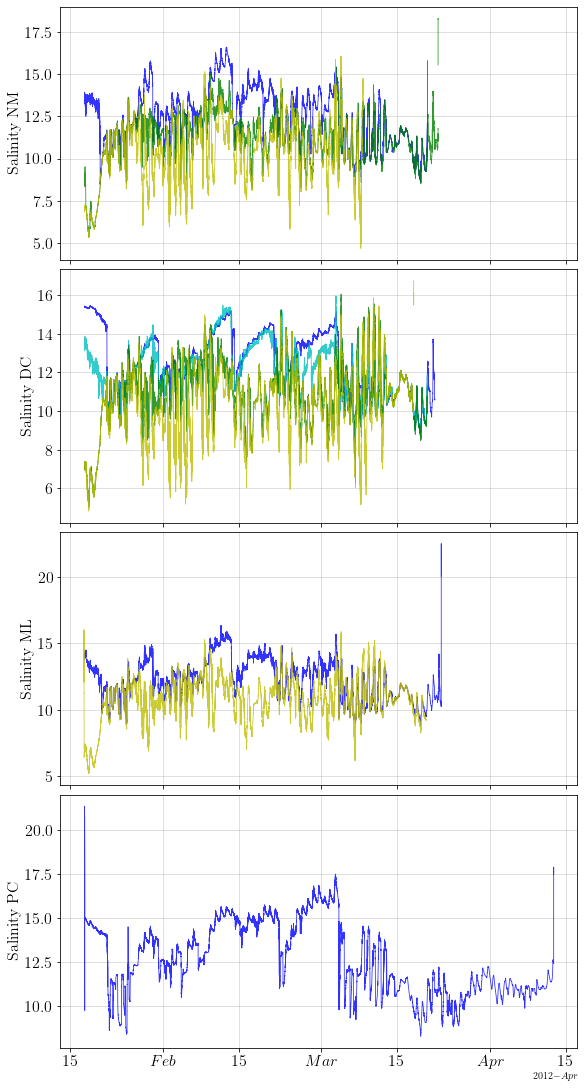

In [69]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, figsize=(8, 15), constrained_layout=True, sharex=True)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

ax1.set_ylabel(r"Salinity NM ",
          fontsize=16)

ax1.plot(NM_1.index, NM_1["Temperature"].values, c='b', alpha=0.8, linewidth=0.8, label='top-bottom')
# ax1.plot(NM_1.index, NM_1["Sal_del"].values, c='b', alpha=0.8, linewidth=0.8, label='top-bottom')

ax1.plot(NM_2.index, NM_2["Temperature"].values, c='g', alpha=0.8, linewidth=0.8, label='top-bottom')
# ax1.plot(NM_2.index, NM_2["Sal_del"].values, c='g', alpha=0.8, linewidth=0.8, label='top-bottom')

ax1.plot(NM_3.index, NM_3["Temperature"].values, c='y', alpha=0.8, linewidth=0.8, label='top-bottom')
# ax1.plot(NM_3.index, NM_3["Sal_del"].values, c='y', alpha=0.8, linewidth=0.8, label='top-bottom')

ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)
ax1.grid(alpha=0.5)

ax2.set_ylabel(r"Salinity DC",
          fontsize=16)

ax2.plot(DC_1.index, DC_1["Temperature"].values, c='b', alpha=0.8, linewidth=0.8, label='top-bottom')
# ax2.plot(DC_1.index, DC_1["Sal_del"].values, c='b', alpha=0.8, linewidth=0.8, label='top-bottom')

ax2.plot(DC_2.index, DC_2["Temperature"].values, c='c', alpha=0.8, linewidth=0.8, label='top-bottom')
# ax2.plot(DC_2.index, DC_2["Sal_del"].values, c='c', alpha=0.8, linewidth=0.8, label='top-bottom')

ax2.plot(DC_3.index, DC_3["Temperature"].values, c='g', alpha=0.8, linewidth=0.8, label='top-bottom')
# ax2.plot(DC_3.index, DC_3["Sal_del"].values, c='g', alpha=0.8, linewidth=0.8, label='top-bottom')

ax2.plot(DC_4.index, DC_4["Temperature"].values, c='y', alpha=0.8, linewidth=0.8, label='top-bottom')
# ax2.plot(DC_4.index, DC_4["Sal_del"].values, c='y', alpha=0.8, linewidth=0.8, label='top-bottom')

ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)
ax2.grid(alpha=0.5)

# ax2.set_xlim(datetime(2012,1,17,14,0,0), datetime(2012,1,21,12,0,0))
ax3.set_ylabel(r"Salinity ML ",
          fontsize=16)

ax3.plot(ML_1.index, ML_1["Temperature"].values, c='b', alpha=0.8, linewidth=0.8, label='top-bottom')
# ax3.plot(ML_1.index, ML_1["Sal_del"].values, c='b', alpha=0.8, linewidth=0.8, label='top-bottom')

ax3.plot(ML_2.index, ML_2["Temperature"].values, c='y', alpha=0.8, linewidth=0.8, label='top-bottom')
# ax3.plot(ML_2.index, ML_2["Sal_del"].values, c='y', alpha=0.8, linewidth=0.8, label='top-bottom')



ax3.xaxis.set_tick_params(labelsize=16)
ax3.yaxis.set_tick_params(labelsize=16)
ax3.grid(alpha=0.5)


ax4.set_ylabel(r"Salinity PC ",
          fontsize=16)

ax4.plot(PC_1.index, PC_1["Temperature"].values, c='b', alpha=0.8, linewidth=0.8, label='top-bottom')
# ax4.plot(PC_1.index, PC_1["Sal_del"].values, c='b', alpha=0.8, linewidth=0.8, label='top-bottom')


ax4.xaxis.set_tick_params(labelsize=16)
ax4.yaxis.set_tick_params(labelsize=16)
ax4.grid(alpha=0.5)


# Ajustar formato fecha
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)

In [171]:
DC_1.index.name = "time"
DC_1.columns.name = "variables"
dc1a = xr.DataArray(DC_1)
DC_2.index.name = "time"
DC_2.columns.name = "variables"
dc2a = xr.DataArray(DC_2)
DC_3.index.name = "time"
DC_3.columns.name = "variables"
dc3a = xr.DataArray(DC_3)
DC_4.index.name = "time"
DC_4.columns.name = "variables"
dc4a = xr.DataArray(DC_4)

In [172]:
NM_1.index.name = "time"
NM_1.columns.name = "variables"
nm1a = xr.DataArray(NM_1)
NM_2.index.name = "time"
NM_2.columns.name = "variables"
nm2a = xr.DataArray(NM_2)
NM_3.index.name = "time"
NM_3.columns.name = "variables"
nm3a = xr.DataArray(NM_3)

In [173]:
ML_1.index.name = "time"
ML_1.columns.name = "variables"
ml1a = xr.DataArray(ML_1)
ML_2.index.name = "time"
ML_2.columns.name = "variables"
ml2a = xr.DataArray(ML_2)

In [174]:
PC_1.index.name = "time"
PC_1.columns.name = "variables"
pc1a = xr.DataArray(PC_1)

In [175]:
NMds = xr.concat([nm1a, nm2a, nm3a], pd.Index([1, 2, 3], name="sensor"))

In [176]:
DCds = xr.concat([dc1a, dc2a, dc3a, dc4a], pd.Index([1, 2, 3, 4], name="sensor"))

In [177]:
MLds = xr.concat([ml1a, ml2a], pd.Index([1, 2], name="sensor"))

In [178]:
PCds = xr.concat([pc1a], pd.Index([1], name="sensor"))

## Densidad

In [179]:
rho_dc1 = to_density(DCds.sel(variables="Depth").sel(sensor=1), DCds.sel(variables="Sal_del").sel(sensor=1), DCds.sel(variables="Temperature").sel(sensor=1), 37.26)
rho_dc2 = to_density(DCds.sel(variables="Depth").sel(sensor=2), DCds.sel(variables="Sal_del").sel(sensor=2), DCds.sel(variables="Temperature").sel(sensor=2), 37.26)
rho_dc3 = to_density(DCds.sel(variables="Depth").sel(sensor=3), DCds.sel(variables="Sal_del").sel(sensor=3), DCds.sel(variables="Temperature").sel(sensor=3), 37.26)
rho_dc4 = to_density(DCds.sel(variables="Depth").sel(sensor=4), DCds.sel(variables="Sal_del").sel(sensor=4), DCds.sel(variables="Temperature").sel(sensor=4), 37.26)
rho_dc = xr.concat([rho_dc1, rho_dc2, rho_dc3, rho_dc4], "sensor")
rho_dc = rho_dc.assign_coords(variables=("Density"))

In [180]:
DC_ds = xr.concat([DCds, rho_dc], dim="variables")

In [181]:
rho_nm1 = to_density(NMds.sel(variables="Depth").sel(sensor=1), NMds.sel(variables="Sal_del").sel(sensor=1), NMds.sel(variables="Temperature").sel(sensor=1), 37.26)
rho_nm2 = to_density(NMds.sel(variables="Depth").sel(sensor=2), NMds.sel(variables="Sal_del").sel(sensor=2), NMds.sel(variables="Temperature").sel(sensor=2), 37.26)
rho_nm3 = to_density(NMds.sel(variables="Depth").sel(sensor=3), NMds.sel(variables="Sal_del").sel(sensor=3), NMds.sel(variables="Temperature").sel(sensor=3), 37.26)
rho_nm = xr.concat([rho_nm1, rho_nm2, rho_nm3], "sensor")
rho_nm = rho_nm.assign_coords(variables=("Density"))

In [182]:
NM_ds = xr.concat([NMds, rho_nm], dim="variables")

In [183]:
rho_ml1 = to_density(MLds.sel(variables="Depth").sel(sensor=1), MLds.sel(variables="Sal_del").sel(sensor=1), MLds.sel(variables="Temperature").sel(sensor=1), 37.26)
rho_ml2 = to_density(MLds.sel(variables="Depth").sel(sensor=2), MLds.sel(variables="Sal_del").sel(sensor=2), MLds.sel(variables="Temperature").sel(sensor=2), 37.26)
rho_ml = xr.concat([rho_ml1, rho_ml2], "sensor")
rho_ml = rho_ml.assign_coords(variables=("Density"))

In [184]:
ML_ds = xr.concat([MLds, rho_ml], dim="variables")

In [185]:
rho_pc1 = to_density(PCds.sel(variables="Depth").sel(sensor=1), PCds.sel(variables="Sal_del").sel(sensor=1), PCds.sel(variables="Temperature").sel(sensor=1), 37.26)
rho_pc = xr.concat([rho_pc1], "sensor")
rho_pc = rho_pc.assign_coords(variables=("Density"))

In [186]:
PC_ds = xr.concat([PCds, rho_pc], dim="variables")

In [187]:
DC_ds.to_netcdf("data/DC_CTD")
NM_ds.to_netcdf("data/NM_CTD")
ML_ds.to_netcdf("data/ML_CTD")
PC_ds.to_netcdf("data/PC_CTD")

## Arreglar ultimos puntos malos

In [56]:
DC_CTD = xr.open_dataset("data//DC_CTD")
NM_CTD = xr.open_dataset("data//NM_CTD")
ML_CTD = xr.open_dataset("data//ML_CTD")
PC_CTD = xr.open_dataset("data//PC_CTD")

In [57]:
DC_CTD['v'] = DC_CTD['__xarray_dataarray_variable__']
DC_CTD = DC_CTD.drop(['__xarray_dataarray_variable__'])

NM_CTD['v'] = NM_CTD['__xarray_dataarray_variable__']
NM_CTD = NM_CTD.drop(['__xarray_dataarray_variable__'])

ML_CTD['v'] = ML_CTD['__xarray_dataarray_variable__']
ML_CTD = ML_CTD.drop(['__xarray_dataarray_variable__'])

PC_CTD['v'] = PC_CTD['__xarray_dataarray_variable__']
PC_CTD = PC_CTD.drop(['__xarray_dataarray_variable__'])

In [59]:
t10 = datetime(2012,2,12,1,31,40)

DC_CTD = DC_CTD.where(DC_CTD.time!=t10)

In [41]:
DC_CTD.sel(sensor=2)

<xarray.Dataset>
Dimensions:    (time: 555766, variables: 5)
Coordinates:
  * variables  (variables) object 'Depth' 'Salinity' ... 'Sal_del' 'Density'
    sensor     int64 2
Dimensions without coordinates: time
Data variables:
    v          (time, variables) float64 ...

In [44]:
DC_CTD.sel(sensor=2)

<xarray.Dataset>
Dimensions:    (time: 555766, variables: 5)
Coordinates:
  * time       (time) datetime64[ns] 2012-01-17T14:00:00 ... 2012-03-21T21:47:30
  * variables  (variables) object 'Depth' 'Salinity' ... 'Sal_del' 'Density'
    sensor     int64 2
Data variables:
    v          (time, variables) float64 ...

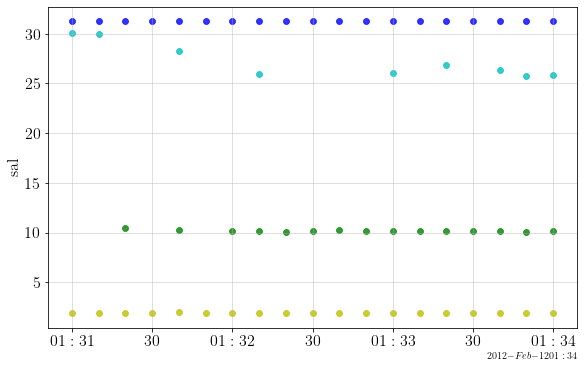

In [60]:
sal = DC_CTD.sel(variables="Sal_del").sel(time=slice("2012-02-12 01:31:00","2012-02-12 01:34:00"))
dens = DC_CTD.sel(variables="Density").sel(time=slice("2012-02-11 01:30:00","2012-02-19 02:00:00"))

fig, (ax1) = plt.subplots(nrows=1, figsize=(8, 5), constrained_layout=True, sharex=True)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

ax1.set_ylabel(r"sal ",
          fontsize=16)

ax1.scatter(sal.time, sal.sel(sensor=1).v, c='b', alpha=0.8, linewidth=0.8, label='top-bottom')
ax1.scatter(sal.time, sal.sel(sensor=2).v, c='c', alpha=0.8, linewidth=0.8, label='top-bottom')
ax1.scatter(sal.time, sal.sel(sensor=3).v, c='g', alpha=0.8, linewidth=0.8, label='top-bottom')
ax1.scatter(sal.time, sal.sel(sensor=4).v, c='y', alpha=0.8, linewidth=0.8, label='top-bottom')

ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)
ax1.grid(alpha=0.5)




# Ajustar formato fecha
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)